In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from datetime import datetime
#from prophet import Prophet

pd.options.display.max_columns = None

In [51]:
AccidentsDataset = pd.read_csv('/content/drive/MyDrive/Maestría/Datos/AccidentsConsolidatedDataset.csv',sep=',')
AccidentsDataset['FECHA']=AccidentsDataset['Unnamed: 0']
AccidentsDataset['FECHA'] = pd.to_datetime(AccidentsDataset['FECHA'])
AccidentsDataset.index = AccidentsDataset['FECHA']
AccidentsDataset=AccidentsDataset.drop(columns=['Unnamed: 0','FECHA'])

In [52]:
AccidentsDataset.head()

,CONTEO,ANHO,MES,DIA,DIA_SEMANA
FECHA,,,,,
2015-01-01,13,2015,1,1,3
2015-01-02,68,2015,1,2,4
2015-01-03,69,2015,1,3,5
2015-01-04,78,2015,1,4,6
2015-01-05,57,2015,1,5,0


In [53]:
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
labelencoder = LabelEncoder()
_categorical_columns=AccidentsDataset.select_dtypes("object").columns
for i in _categorical_columns:
    AccidentsDataset[i]=AccidentsDataset[i].fillna("No Registra") 
for i in _categorical_columns:
    print(i)
    AccidentsDataset[i]=labelencoder.fit_transform(AccidentsDataset[i])

In [54]:
training_regressor = DecisionTreeRegressor(random_state=1)
x_train,x_test,y_train,y_test = train_test_split(AccidentsDataset.drop(columns=['CONTEO']),AccidentsDataset.CONTEO,test_size = 0.30 ,random_state = 2)
training_regressor_params = {'max_depth':np.arange(1,50,2),'min_samples_leaf':np.arange(2,15)}

from sklearn.model_selection import GridSearchCV
gs_training_regressor = GridSearchCV(training_regressor,training_regressor_params,cv=3)
gs_training_regressor.fit(x_train,y_train)
a = gs_training_regressor.best_params_
print(a)
training_regressor.fit(x_train,y_train)
predictions = gs_training_regressor.predict(x_test)

{'max_depth': 3, 'min_samples_leaf': 3}


In [55]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

msle=mean_squared_log_error(predictions,y_test)
rmsle=np.sqrt(msle)
print('RMLSE for the data:',rmsle,' MSLE:',mean_squared_log_error) # For decision tree

print('MAE:',mean_absolute_error(predictions,y_test))
print('MSE:',mean_squared_error(predictions,y_test))
print('RMSE:',np.sqrt(mean_squared_error(predictions,y_test)))

RMLSE for the data: 0.23454991203904849  MSLE: <function mean_squared_log_error at 0x7f543788cf80>
MAE: 14.601849194687334
MSE: 374.99027919055067
RMSE: 19.364665739189785


In [56]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
training_model=rf.fit(x_train, y_train)
predictions_rf = rf.predict(x_test)

In [57]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

msle=mean_squared_log_error(predictions_rf,y_test)
rmsle=np.sqrt(msle)

print('MAE:',mean_absolute_error(predictions_rf,y_test))
print('MSE:',mean_squared_error(predictions_rf,y_test))
print('RMSE:',np.sqrt(mean_squared_error(predictions_rf,y_test)))

MAE: 15.110301094890511
MSE: 377.2027411989051
RMSE: 19.42170798871472


In [58]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(solver='adam', alpha=0.001,hidden_layer_sizes=(100,100,1), random_state=1,max_iter=100)
nn.fit(x_train, y_train)
predictions_nn_lbfgs=nn.predict(x_test)
print(mean_absolute_error(y_test, predictions_nn_lbfgs))
print(mean_squared_error(y_test, predictions_nn_lbfgs))
print('RMSE:',np.sqrt(mean_squared_error(predictions_nn_lbfgs,y_test)))

93.64592447112173
9301.507062852994
RMSE: 96.44432105029821


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [59]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.0001, 0.00001],
        'alpha': [3, 4, 5,10],
        }

In [60]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
data_dmatrix = xgb.DMatrix(data=AccidentsDataset.drop(columns=['CONTEO']),label=AccidentsDataset.CONTEO)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror' ,learning_rate = 0.01,n_estimators = 1500,eval_metric="rmse")


In [61]:
"""folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=xg_reg, param_grid=params, scoring='r2', n_jobs=4, cv=skf.split(x_train,y_train), verbose=3 )
grid.fit(x_train,y_train)
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)
results = pd.DataFrame(grid.cv_results_)
results.to_csv('/content/drive/MyDrive/Maestría/Datos/xgb-grid-search-results-01.csv', index=False)"""

Fitting 3 folds for each of 4860 candidates, totalling 14580 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  3.0min


KeyboardInterrupt: ignored

In [68]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror' ,n_estimators = 1500,eval_metric="rmse",alpha= 3, colsample_bytree= 1.0, gamma= 2, learning_rate= 0.01, max_depth= 3, min_child_weight= 1, subsample= 0.8)
xg_reg.fit(x_train,y_train)
preds_xg = xg_reg.predict(x_test)

In [69]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

msle=mean_squared_log_error(predictions_rf,y_test)
rmsle=np.sqrt(msle)

print('MAE:',mean_absolute_error(preds_xg,y_test))
print('MSE:',mean_squared_error(preds_xg,y_test))
print('RMSE:',np.sqrt(mean_squared_error(preds_xg,y_test)))

MAE: 14.106261796324793
MSE: 343.7558383582262
RMSE: 18.54065366588315


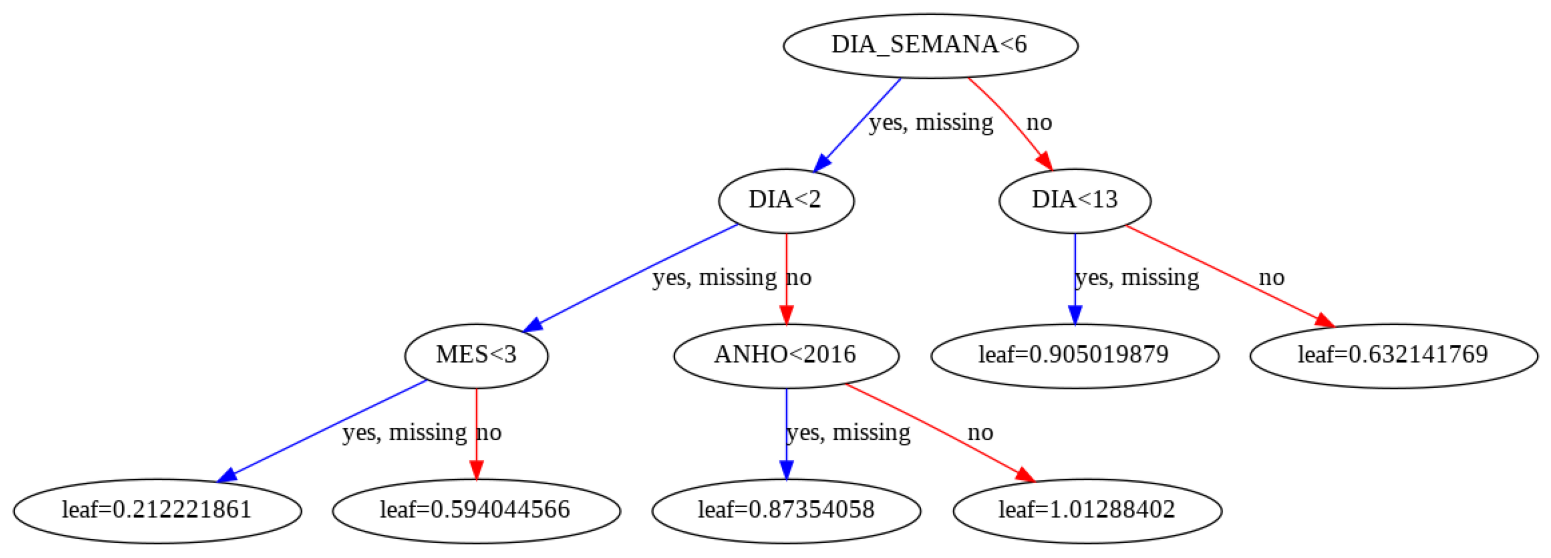

In [70]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=1)
plt.rcParams['figure.figsize'] = [50, 10]
plt.savefig('/content/drive/MyDrive/Maestría/Datos/treeXGBoost.png')

In [72]:
print(x_test[0:30].index,)

DatetimeIndex(['2019-12-05', '2019-08-03', '2016-11-25', '2019-07-18',
               '2019-09-07', '2018-02-16', '2015-10-29', '2016-04-29',
               '2015-02-22', '2019-06-17', '2015-08-29', '2019-09-11',
               '2019-12-09', '2016-12-08', '2015-12-11', '2018-11-17',
               '2015-06-07', '2018-10-28', '2017-06-26', '2019-10-03',
               '2017-05-27', '2017-01-09', '2016-05-20', '2018-10-12',
               '2019-09-12', '2019-09-27', '2019-05-20', '2018-04-08',
               '2016-01-04', '2016-05-03'],
              dtype='datetime64[ns]', name='FECHA', freq=None)


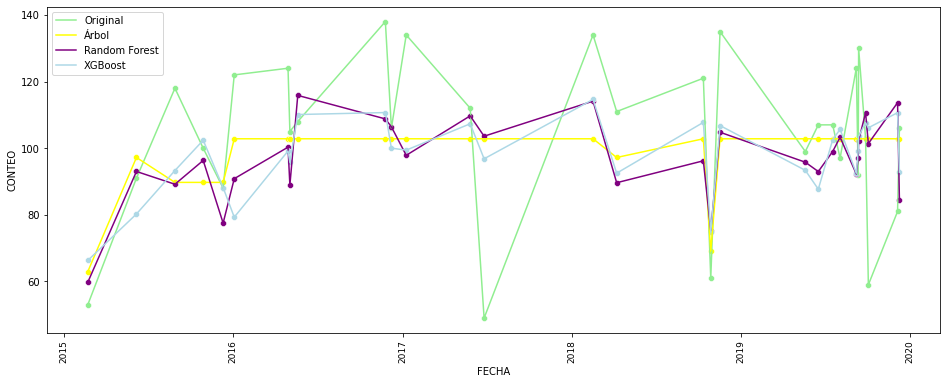

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90, fontsize=9)
sns.scatterplot(x=x_test[0:30].index,y=y_test[0:30],color='lightgreen',legend='auto')
sns.lineplot(x=x_test[0:30].index,y=y_test[0:30],color='lightgreen',legend='auto',label='Original')
sns.scatterplot(x=x_test[0:30].index,y=predictions[0:30],color='yellow',legend='auto')
sns.lineplot(x=x_test[0:30].index,y=predictions[0:30],color='yellow',legend='auto',label='Árbol')
sns.scatterplot(x=x_test[0:30].index,y=predictions_rf[0:30],color='purple',legend='auto')
sns.lineplot(x=x_test[0:30].index,y=predictions_rf[0:30],color='purple',legend='auto',label='Random Forest')
sns.scatterplot(x=x_test[0:30].index,y=preds_xg[0:30],color='lightblue',legend='auto')
sns.lineplot(x=x_test[0:30].index,y=preds_xg[0:30],color='lightblue',legend='auto',label='XGBoost')
plt.legend()
plt.show()

# Dataset sintético

In [63]:
import datetime

curr_date = datetime.datetime(2020, 12, 31)

In [64]:
dataList = []
print(curr_date)
for i in range(0,7):
  curr_date = curr_date + datetime.timedelta(days=1)
  dataList.append({"FECHA":curr_date,"ANHO":curr_date.year,"MES":curr_date.month,"DIA":curr_date.day,"DIA_SEMANA":curr_date.weekday()})
mock_dataset = pd.DataFrame(dataList)
mock_dataset.index=(mock_dataset["FECHA"])
mock_dataset=mock_dataset.drop(columns=["FECHA"])
mock_dataset.head()

2020-12-31 00:00:00


,ANHO,MES,DIA,DIA_SEMANA
FECHA,,,,
2021-01-01,2021,1,1,4
2021-01-02,2021,1,2,5
2021-01-03,2021,1,3,6
2021-01-04,2021,1,4,0
2021-01-05,2021,1,5,1


In [65]:
predictions_for_mock=training_regressor.predict(mock_dataset)
print(predictions_for_mock)

[ 45.  67. 113.  97. 118.  64. 111.]


In [66]:
results_series =np.array([114,114,103,89,94,102,94])

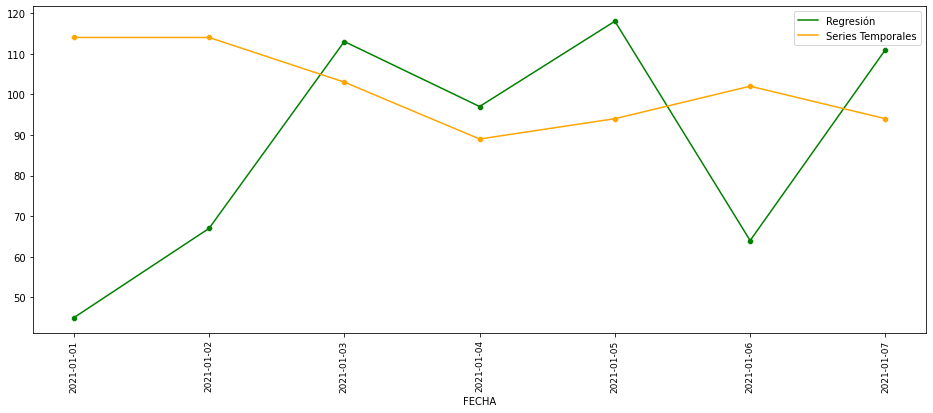

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90, fontsize=9)
sns.scatterplot(x=mock_dataset.index,y=predictions_for_mock,color='green',legend='auto')
sns.lineplot(x=mock_dataset.index,y=predictions_for_mock,color='green',label='Regresión')
sns.scatterplot(x=mock_dataset.index,y=results_series,color='orange',legend='auto')
sns.lineplot(x=mock_dataset.index,y=results_series,color='orange',label='Series Temporales')
plt.legend()
plt.show()